In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem import WordNetLemmatizer
import unidecode
from sklearn.naive_bayes import MultinomialNB

In [36]:
onion= pd.read_csv('data/TheOnion_200331_212130.csv')

In [37]:
not_onion= pd.read_csv('data/nottheonion_200331_222109.csv')

In [38]:
news=pd.concat([onion, not_onion]).reset_index(drop=True)

In [39]:
news.tail()

,created_utc,url,id,num_comments,title,subreddit,timestamp
19995,1581806730,https://www.reddit.com/r/nottheonion/comments/...,f4h4xr,1,Florida Snake orgy,nottheonion,2020-02-16 03:45:30
19996,1581806241,https://www.reddit.com/r/nottheonion/comments/...,f4h0xm,10,Sheriff’s ‘out of the ordinary’ call: bear arm...,nottheonion,2020-02-16 03:37:21
19997,1581805471,https://www.reddit.com/r/nottheonion/comments/...,f4gush,2,Male Tennessee lawmaker concerned women will s...,nottheonion,2020-02-16 03:24:31
19998,1581805139,https://www.reddit.com/r/nottheonion/comments/...,f4grxn,204,New technology may prevent McDonald’s ice crea...,nottheonion,2020-02-16 03:18:59
19999,1581804630,https://www.reddit.com/r/nottheonion/comments/...,f4gnqi,1,Tanner Zipchen speaks out on former Cineplex g...,nottheonion,2020-02-16 03:10:30


In [40]:
news['subreddit']= news['subreddit'].map(lambda x: 1 if x== 'TheOnion' else 0)

In [41]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
created_utc     20000 non-null int64
url             20000 non-null object
id              20000 non-null object
num_comments    20000 non-null int64
title           20000 non-null object
subreddit       20000 non-null int64
timestamp       20000 non-null object
dtypes: int64(3), object(4)
memory usage: 781.3+ KB


In [42]:
news.head()

,created_utc,url,id,num_comments,title,subreddit,timestamp
0,1585666673,https://www.reddit.com/r/TheOnion/comments/fse...,fsecot,1,Prison Economy Spirals As Price Of Pack Of Cig...,1,2020-03-31 19:57:53
1,1585666583,https://www.reddit.com/r/TheOnion/comments/fse...,fsebut,0,Prison Economy Spirals As Price Of Pack Of Cig...,1,2020-03-31 19:56:23
2,1585664848,https://www.reddit.com/r/TheOnion/comments/fsd...,fsduf7,0,Trump Delays Easter To July 15 To Keep Promise...,1,2020-03-31 19:27:28
3,1585653596,https://www.reddit.com/r/TheOnion/comments/fsb...,fsb69r,0,"‘What Is This Strange Sensation,’ Announces Na...",1,2020-03-31 16:19:56
4,1585653517,https://www.reddit.com/r/TheOnion/comments/fsb...,fsb5ns,6,"Amazon Announces Unlimited Time Off, Increased...",1,2020-03-31 16:18:37


In [43]:
wpt= nltk.WordPunctTokenizer()
stop_words= nltk.corpus.stopwords.words('english')
lemmatizer= WordNetLemmatizer()
def normalize(title):
    title= unidecode.unidecode(title)
    title= re.sub(r"[^a-zA-Z\s]", '', title)
    title= title.lower()
    title= title.strip()
    title = title.replace('  ',' ')
    tokens= wpt.tokenize(title)
    filtered_tokens= [token for token in tokens if token not in stop_words]
    lemmatized_tokens=[lemmatizer.lemmatize(token) for token in filtered_tokens]
    clean_title=' '.join(lemmatized_tokens)
    return clean_title

   
    

In [44]:
titles= list(news['title'])
for index,title in enumerate(titles):
    news['title'][index]= normalize(title)

c:\users\bisma\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
news['title'].str.contains("'").sum()

0

In [46]:
import sklearn
from sklearn.model_selection import train_test_split

In [47]:
news.drop_duplicates(subset='title', inplace=True)


In [48]:
y= news['subreddit']
X= news['title']


In [49]:

X_train, X_test,y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
#naive classifier:
TP= np.sum(news['subreddit'])
FP= news['subreddit'].count() - TP
TN=0
FN=0
baseline= (TP+TN)/ (TP+FP+TN+FN)

recall= (TP) / (TP +FN)
precision= (TP)/ (TP + FP)
fscore = (1 + 0.5**2) * ((precision * recall) / ((0.5**2 * precision) + recall))

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(baseline, fscore))

Naive Predictor: [Accuracy score: 0.5591, F-score: 0.6131]


In [51]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=1)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec= TfidfVectorizer()
X_train_tvec= tvec.fit_transform(X_train)
tvec_score= cross_val_score(lr, X_train_tvec, y_train, cv=3)
print(tvec_score)
print(X_train_tvec.shape)

[0.82271985 0.82295311 0.81614559]
(12860, 17190)


In [53]:
from sklearn.feature_extraction.text import CountVectorizer
cvec= CountVectorizer()
X_train_cvec= cvec.fit_transform(X_train)
cvec_score= cross_val_score(lr, X_train_cvec, y_train, cv=3)
print(cvec_score)
print(X_train_cvec.shape)


[0.82925122 0.82948449 0.82081195]
(12860, 17190)


In [54]:
print ('Baseline:', baseline)
print ('Tfidf Vectorizer Score:', tvec_score.mean())
print ('Count Vectorizer Score:', cvec_score.mean())
acc_list = []
acc_list.append(cvec_score.mean())
acc_list.append(tvec_score.mean())

# DataFrame Accuracy 
acc_df = pd.DataFrame()
acc_df['params']= ['cvec', 'tvec']
acc_df['scores']= acc_list
acc_df

Baseline: 0.5590668740279938
Tfidf Vectorizer Score: 0.8206061850237379
Count Vectorizer Score: 0.8265158861632743


,params,scores
0,cvec,0.826516
1,tvec,0.820606


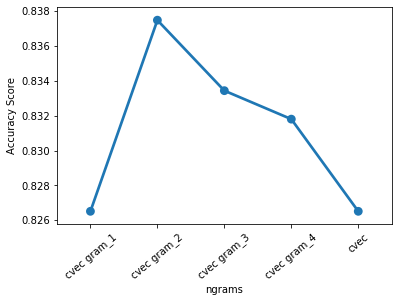

In [55]:
def count_vec_ngram(params, X_train, y_train):
    cvec_p = CountVectorizer(ngram_range=(params))
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
# cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
# cross validation 
    return cvec_score_p.mean()

params = [(1,1), (1,2),(1,3), (1,4)] 
ngram_scores = []
for p in params:
    ngram_scores.append(count_vec_ngram(p, X_train, y_train))
    
ngrams = ['cvec gram_1','cvec gram_2','cvec gram_3','cvec gram_4']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2,3])
# adding cvec score with default params
ngram_df = ngram_df.append(acc_df.iloc[:1,:])
# plot scores on graph
sns.pointplot(x='params', y='scores', data =ngram_df)
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.xticks(rotation=40)
plt.show()

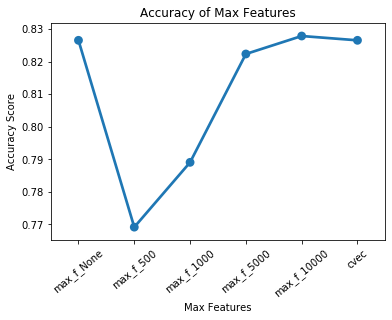

In [56]:
def count_vec_max_features(params, X_train, y_train):
    cvec_p = CountVectorizer(max_features=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
# cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
# cross validation 
    return cvec_score_p.mean()
mf_params = [None, 500, 1000, 5000, 10000]
max_features_scores = [count_vec_max_features(p, X_train, y_train) for p in mf_params]
max_features = ['max_f_'+str(p) for p in mf_params]
# dataframe for scores
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
# adding cvec score with default params
max_features_df = max_features_df.append(acc_df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('Max Features')
plt.xticks(rotation=40)
plt.title('Accuracy of Max Features')
plt.show()

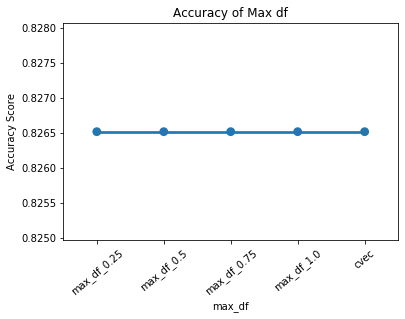

In [57]:
def count_vec_max_df(params, X_train, y_train):
    cvec_p = CountVectorizer(max_df=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
# cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
# cross validation 
    return cvec_score_p.mean()
mdf_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [count_vec_max_df(p, X_train, y_train) for p in mdf_params]
max_df = ['max_df_'+str(p) for p in mdf_params]
# dataframe for scores
max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
# adding cvec score with default params
max_df_df = max_df_df.append(acc_df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.xticks(rotation=40)
plt.title('Accuracy of Max df')
plt.show()

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
# initalise the vectoriser 
cvec_b = CountVectorizer(ngram_range=(1,2), max_features=None)
# fit the training data on the model
cvec_b.fit(X_train)
#transform training data into sparse matrix
X_train_cvec = cvec_b.transform(X_train)
# cross val score/ predict
cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3)
cvec_score.mean()
acc_df.loc[8]= ['best_params', cvec_score.mean()]
acc_df.sort_values('scores', ascending=False)

,params,scores
8,best_params,0.837480
0,cvec,0.826516
1,tvec,0.820606


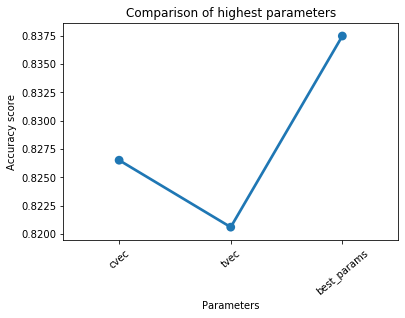

In [59]:
sns.pointplot(x='params', y='scores', data =acc_df)
plt.ylabel('Accuracy score')
plt.xlabel('Parameters')
plt.xticks(rotation=40)
plt.title('Comparison of highest parameters')
plt.show()

In [60]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {
               'cvec__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8374019991855919
Train score 0.9959564541213064
Test score 0.8538102643856921


{'cvec__ngram_range': (1, 2), 'lr__C': 1}

In [61]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.25,.5,.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3), (1,4)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8263603591188936
Train score 0.9209953343701399
Test score 0.83950233281493


{'lr__C': 1,
 'tvect__max_df': 0.25,
 'tvect__min_df': 2,
 'tvect__ngram_range': (1, 4)}

In [62]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8483663564797413
Train score 0.9942457231726283
Test score 0.8578538102643857


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.6}

In [63]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8256609642301711
Train score 0.8976671850699844
Test score 0.8289269051321928


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}